In [8]:
# % cd..

In [3]:
import numpy as np

from scipy.signal import stft
from scipy.io import wavfile

import matplotlib.pyplot as plt


def draw_spec(amp, time=None, freq=None, title='',
              new_plot=True, figure_size=(10, 8)):
    """
    Draws spectrum
    :param amp: 2D numpy array of shape (freq, time)
    :param time: 1D numpy array of actual time
    :param freq: 1D numpy array of actual frequency
    :param title: Title of the plot
    :param new_plot: whether draws on new figure
    """
    if new_plot:
        plt.figure(figsize=figure_size)
        plt.title(title)
        plt.xlabel('Time (s)')
        plt.ylabel('Freq (Hz)')
    if time is None:
        time = np.arange(amp.shape[1])
    if freq is None:
        freq = np.arange(amp.shape[0])
    plt.pcolormesh(time, freq, amp, shading='auto', cmap=plt.cm.plasma)
    plt.colorbar()


""


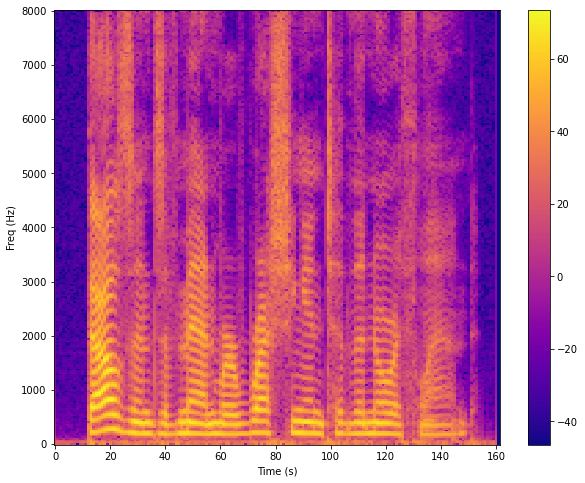

In [4]:
from scipy.fft import dct

from utils import db_to_amp
from metadata import vcc


def log_stft(amp, dynamic_range=120):
    """
    :param amp: amplitude
    :param dynamic_range: in db
    :return: time (1D array), frequencies (1D array), log amplitude
        log_amp is (num_freq, num_time) numpy array, in decibels

    Note on dynamic_range:
    -------
    Assuming that the weakest detectable sound is 0 db, then the loudest
    possible sound is 194 db.

    db = 20 * log_10(amp)
    """
    max_amp = np.max(amp)
    if max_amp == 0:
        return amp
    log_amp = 20 * np.log10(
        np.clip(amp, max_amp / db_to_amp(dynamic_range), np.inf))
    return log_amp


sr, dat = wavfile.read(vcc.train_2016(0, 2))


def sound(x, rate=sr, label=''):
    from IPython.display import display, Audio, HTML
    display(HTML(
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>'
        + label + '</td><td>' + Audio(x, rate=rate)._repr_html_()[3:]
        + '</td></tr></table>'
    ))


sound(dat)

N_FFT = 512
freq, time, zxx = stft(dat, sr, nperseg=N_FFT)
amp = np.abs(zxx)
log_amp = log_stft(amp)

draw_spec(log_amp, freq=freq)

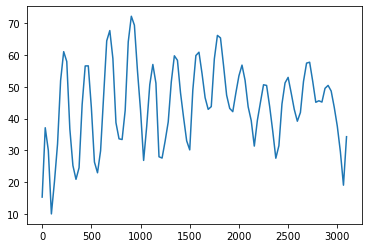

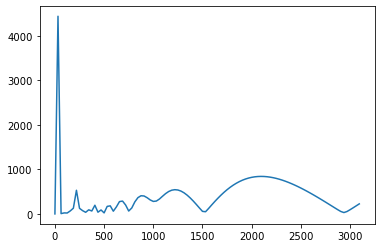

In [23]:
import transform


t = 15
plt.figure()
frame = log_amp[:,t]
fn=100
plt.plot(freq[:fn], frame[:fn])
plt.figure()
mod_ceps = np.abs(transform.mod_cepstrum(frame[:fn]))
mod_ceps[0] = 0
plt.plot(freq[:fn], mod_ceps)

In [12]:
def is_vowel():
    pass

In [13]:
# from IPython import display
# from ipywidgets import widgets
#
# colorpicker = widgets.ColorPicker(
#     concise=False,
#     description='Pick a color',
#     value='black',
#     disabled=False
# )
# display.display(colorpicker)

In [14]:
# from IPython.core.display import Javascript
#
# color = colorpicker.value
# Javascript("""
# let div = document.getElementById('color');
# document.body.style.backgroundColor = "{}";
# """.format(color))
#